In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("Microsoft/microsoft-security-incident-prediction")

# print("Path to dataset files:", path)

# https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction
# https://arxiv.org/abs/2407.09017
# https://www.microsoft.com/en-us/research/publication/microsoft-security-incident-prediction/

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from imblearn.metrics import specificity_score

from sklearn.ensemble import RandomForestClassifier


from plot_helpers import render_plot

pd.set_option('display.max_columns', None)

In [ ]:
df_train = pd.read_csv('DATA/GUIDE_Train.csv')
df_test = pd.read_csv('DATA/GUIDE_Test.csv')

PermissionError: [Errno 1] Operation not permitted: 'DATA/GUIDE_Train.csv'

In [7]:
df_train.shape, df_test.shape

((10000, 45), (10000, 46))

In [8]:
# find the column that is different between the two data sets
set(df_train.columns).symmetric_difference(set(df_test.columns))

{'Usage'}

In [9]:
# explore the value within the Usage column in the test data set
df_test.Usage.value_counts()


Usage
Public     7080
Private    2920
Name: count, dtype: int64

In [10]:
# The usage columns is not present in the training data. And it appears to be a column that indicates how the data should be used. 
# We will drop this column from the test data set
df_test.drop(columns=['Usage'], inplace=True)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 45 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int64  
 1   OrgId               10000 non-null  int64  
 2   IncidentId          10000 non-null  int64  
 3   AlertId             10000 non-null  int64  
 4   Timestamp           10000 non-null  object 
 5   DetectorId          10000 non-null  int64  
 6   AlertTitle          10000 non-null  int64  
 7   Category            10000 non-null  object 
 8   MitreTechniques     4201 non-null   object 
 9   IncidentGrade       9947 non-null   object 
 10  ActionGrouped       59 non-null     object 
 11  ActionGranular      59 non-null     object 
 12  EntityType          10000 non-null  object 
 13  EvidenceRole        10000 non-null  object 
 14  DeviceId            10000 non-null  int64  
 15  Sha256              10000 non-null  int64  
 16  IpAdd

In [12]:
cat_columns = ['Category', 'EntityType', 'EvidenceRole', 'SuspicionLevel', 'LastVerdict',
               'ResourceType', 'Roles', 'AntispamDirection', 'ThreatFamily']

numerical_columns = ['DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
                     'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId', 'RegistryKey',
                     'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
                     'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSFamily', 
                     'OSVersion', 'CountryCode', 'State', 'City']

drop_columns = []

In [13]:
# convert timestamp to datetime
df_train['Timestamp'] = pd.to_datetime(df_train['Timestamp'])
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

# convert MitreTechniques to extract first technique
df_train['FirstMitreTechnique'] = df_train['MitreTechniques'].str.split(';').str[0]
df_test['FirstMitreTechnique'] = df_test['MitreTechniques'].str.split(';').str[0]

df_train['FirstMitreTechnique'] = df_train['FirstMitreTechnique'].str.split('.').str[0]
df_test['FirstMitreTechnique'] = df_test['FirstMitreTechnique'].str.split('.').str[0]

# add MitreColumns to be dropped later
drop_columns.append(['MitreTechniques'])

In [14]:
# Find null values in the dataset
null_values = df_train.isnull().sum()
print(null_values.sort_values(ascending=False))

# consider removing columns with more than 80% missing values
#drop_columns.extend(['ResourceType', 'ActionGrouped', 'ActionGranular', 'ThreatFamily', 'EmailClusterId', 'Roles'])
type(drop_columns)


ResourceType           9992
ActionGrouped          9941
ActionGranular         9941
ThreatFamily           9923
EmailClusterId         9881
AntispamDirection      9823
Roles                  9789
SuspicionLevel         8462
LastVerdict            7600
FirstMitreTechnique    5799
MitreTechniques        5799
IncidentGrade            53
RegistryValueName         0
OSFamily                  0
CountryCode               0
State                     0
ResourceIdName            0
FolderPath                0
FileName                  0
City                      0
OAuthApplicationId        0
ApplicationName           0
ApplicationId             0
RegistryValueData         0
OSVersion                 0
Id                        0
RegistryKey               0
OrgId                     0
IncidentId                0
AlertId                   0
Timestamp                 0
DetectorId                0
AlertTitle                0
Category                  0
EntityType                0
EvidenceRole        

list

<Axes: xlabel='IncidentGrade', ylabel='count'>

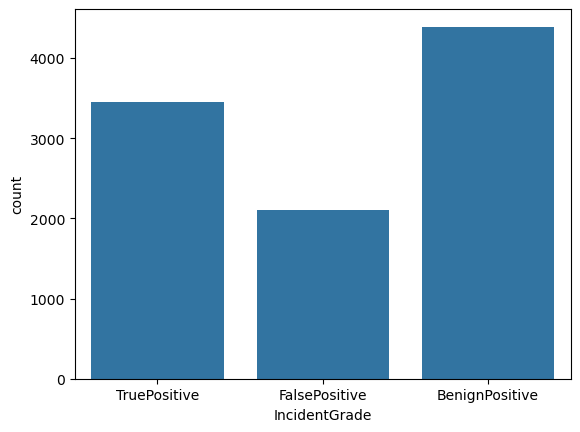

In [15]:
# Explore IncidentGrade
sns.countplot(x='IncidentGrade', data=df_train)

#### Fairly balanced classes

<Axes: xlabel='IncidentGrade', ylabel='count'>

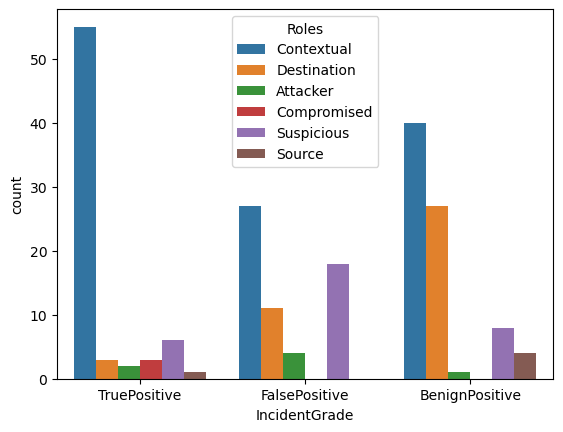

In [16]:
# Explore Roles with IncidentGrade
sns.countplot(x='IncidentGrade', hue='Roles', data=df_train)


In [17]:
# Find all incidents with duplicate AlertIds
duplicate_alerts = df_train[df_train.duplicated('AlertId', keep=False)]

# Show a few sample incidents that are marked true positive
duplicate_alerts[duplicate_alerts['IncidentGrade'] == 'TruePositive'].head(10)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,ActionGrouped,ActionGranular,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,EmailClusterId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,ThreatFamily,FileName,FolderPath,ResourceIdName,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,FirstMitreTechnique
142,154618827802,1216,3333,14741,2024-06-11 15:57:54+00:00,10,8,InitialAccess,T1566.001,TruePositive,NaN,NaN,User,Impacted,98799,138268,360606,160396,135336,422162,137787,159335,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1566
220,927712937952,19,679,2186,2024-06-08 14:13:52+00:00,23,16,CommandAndControl,NaN,TruePositive,NaN,NaN,Url,Related,98799,138268,360606,265,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
326,764504178755,6,2511,1471,2024-06-02 05:43:28+00:00,17,285,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,51079,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
331,197568499533,14,198,247,2024-05-23 11:00:38+00:00,41,84,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,2376,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
418,163208761261,10,2164,105,2024-05-22 19:42:00+00:00,12,704,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,12161,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
451,1073741828573,607,597,1675,2024-06-10 21:09:48+00:00,127,108,SuspiciousActivity,T1586,TruePositive,NaN,NaN,Mailbox,Related,98799,138268,360606,160396,287137,269120,240468,241856,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,T1586
507,249108105137,811,832,41889,2024-06-05 17:25:08+00:00,66,48,InitialAccess,NaN,TruePositive,NaN,NaN,Mailbox,Impacted,98799,138268,360606,160396,29069,47718,29620,31779,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,Malicious,242,1445,10630,NaN
559,335007452987,14,4098,2944,2024-06-01 12:26:54+00:00,29,20,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,23770,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
573,1597727838178,10,2712,464,2024-05-26 14:35:58+00:00,12,782,Impact,NaN,TruePositive,NaN,NaN,Ip,Related,98799,138268,71089,160396,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN
588,1228360648674,19,649,2066,2024-06-01 12:21:53+00:00,23,16,CommandAndControl,NaN,TruePositive,NaN,NaN,Url,Related,98799,138268,360606,592,441377,673934,425863,453297,153085,529644,NaN,1631,635,860,2251,3421,881,NaN,289573,117668,3586,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630,NaN


In [18]:
# for the ratio of Category, and show top 10 categories of alerts
df_train['Category'].value_counts(normalize=True).sort_values(ascending=False).head(10)*100

Category
InitialAccess         45.06
Exfiltration          16.85
SuspiciousActivity    10.35
CommandAndControl      8.97
Impact                 8.15
CredentialAccess       2.92
Execution              2.57
Malware                1.52
Discovery              1.42
Persistence            0.66
Name: proportion, dtype: float64

#### Top categories for logging Incidents and Alerts are InitialAccess, Exfiltration, SuspiciousActivity, CommandA8dControl

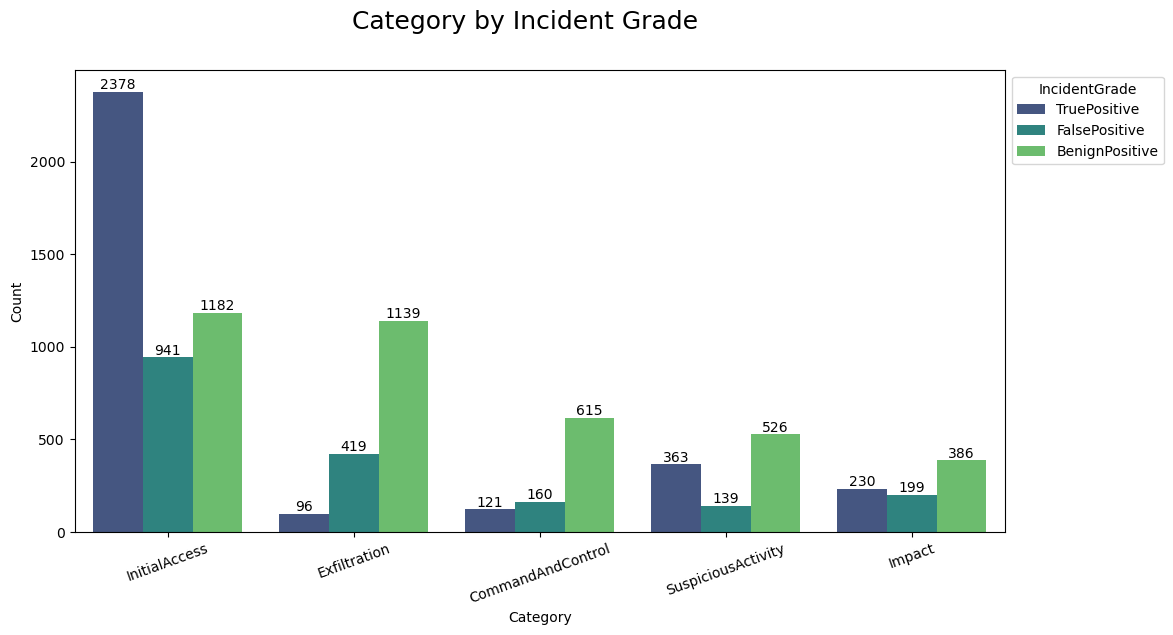

In [19]:
# plot top 5 categories with incident grade

plt.figure(figsize=(12, 6))
top_10_categories = df_train['Category'].value_counts().head(5).index
ax = sns.countplot(data=df_train[df_train['Category'].isin(top_10_categories)], x='Category', hue='IncidentGrade', palette='viridis')

render_plot(ax, heading='Category by Incident Grade', xlabel='Category', ylabel='Count')


#### Exfiltration attemps appear to be last harmful compared to alerts marked as Initial Access, Suspicious or Impact

#### Last Verdict
https://learn.microsoft.com/en-us/defender-xdr/m365d-remediation-actions

In [20]:
# explore the values within LastVerdict
print(df_train['LastVerdict'].value_counts())

# remove LastVerdict values that begin with 'Domain'
df_last_verdict = df_train[~df_train['LastVerdict'].str.startswith('Domain', na=False)]

LastVerdict
Suspicious        1497
Malicious          477
NoThreatsFound     426
Name: count, dtype: int64


In [21]:
# Summarize LastVerdict
print('Number of missing values in Last Verdict are: ', df_last_verdict['LastVerdict'].isna().sum()  )

Number of missing values in Last Verdict are:  7600


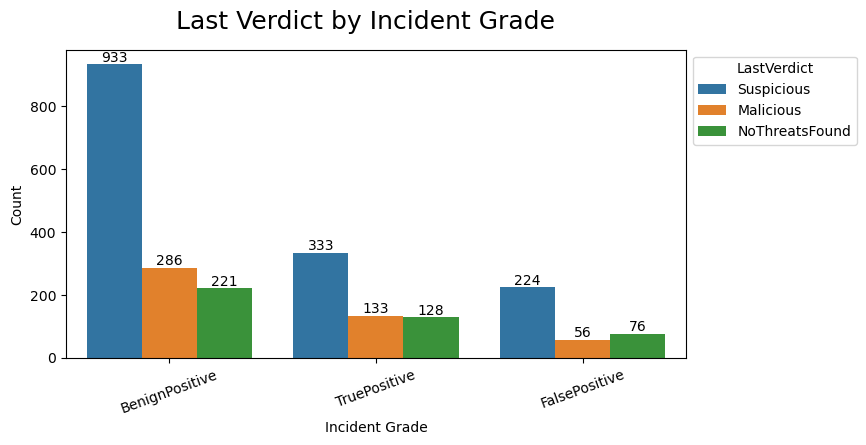

In [22]:
# plot LastVerdict by Incident Grade
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_last_verdict, x='IncidentGrade', hue='LastVerdict', order=df_last_verdict['IncidentGrade'].value_counts().index)

render_plot(ax, heading='Last Verdict by Incident Grade', xlabel='Incident Grade', ylabel='Count')


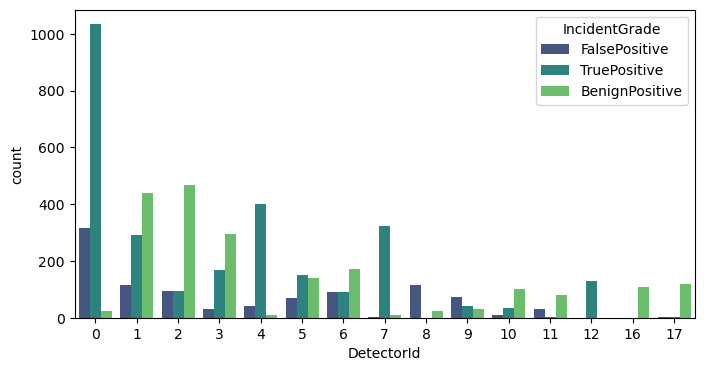

In [23]:
# plot top 10 Detectors by Incident Grade
plt.figure(figsize=(8, 4))
top_10_detectors = df_train['DetectorId'].value_counts().head(15).index
ax = sns.countplot(data=df_train[df_train['DetectorId'].isin(top_10_detectors)], x='DetectorId', hue='IncidentGrade', palette='viridis')

In [24]:
# "DetectorId 0" typically refers to a generic or default detection mechanism, meaning it signifies an alert triggered by a broad security
# rule that isn't specifically tied to a particular security feature or detection method within the XDR platform; it usually indicates a 
# high-level threat that needs further investigation to pinpoint the exact source of the suspicious activity

# check the entity type for DetectorId = 0
df_train[df_train['DetectorId'] == 0]['EntityType'].value_counts()

EntityType
User                 418
CloudLogonRequest    393
Ip                   352
CloudLogonSession    211
Name: count, dtype: int64

### EntityTypes
https://learn.microsoft.com/en-us/azure/sentinel/entities-reference

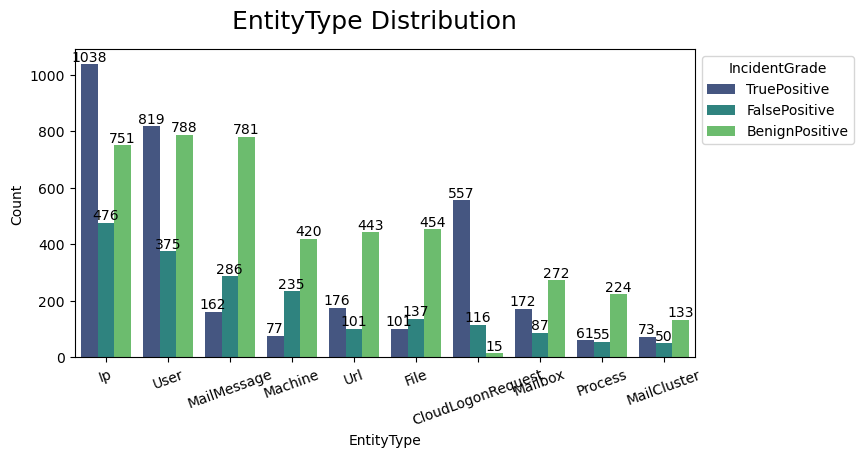

In [25]:
# check the distribution of EntityTypes
plt.figure(figsize=(8, 4))
ax = sns.countplot(data=df_train, x='EntityType', hue='IncidentGrade', order=df_train['EntityType'].value_counts().head(10).index, palette='viridis')
render_plot(ax, heading='EntityType Distribution', xlabel='EntityType', ylabel='Count')


In [26]:
# Explore IncidentId 5447

# df_train[df_train['IncidentId'] == 5447]

In [27]:
#"evidencerole" refers to the specific part a particular piece of evidence plays within a security alert, indicating whether 
# it is the primary target of the attack, a related component, or simply provides supporting context for the incident; 
# essentially, it describes how the evidence is involved in the overall threat scenario

df_train.groupby(['IncidentGrade', 'EvidenceRole']).size().sort_values(ascending=False)  

IncidentGrade   EvidenceRole
BenignPositive  Impacted        2323
TruePositive    Related         2249
BenignPositive  Related         2068
TruePositive    Impacted        1197
FalsePositive   Related         1108
                Impacted        1002
dtype: int64

#### MitreTechniques
https://attack.mitre.org/

In [28]:
df_grouped = df_train.groupby(['IncidentGrade','FirstMitreTechnique']).size().reset_index(name='size')
df_sorted = df_grouped.sort_values(by='size', ascending=False)
df_sorted

,IncidentGrade,FirstMitreTechnique,size
113,TruePositive,T1078,1043
56,BenignPositive,T1566,916
124,TruePositive,T1566,486
86,FalsePositive,T1078,338
101,FalsePositive,T1566,293
...,...,...,...
29,BenignPositive,T1113,1
88,FalsePositive,T1098,1
51,BenignPositive,T1550,1
28,BenignPositive,T1112,1


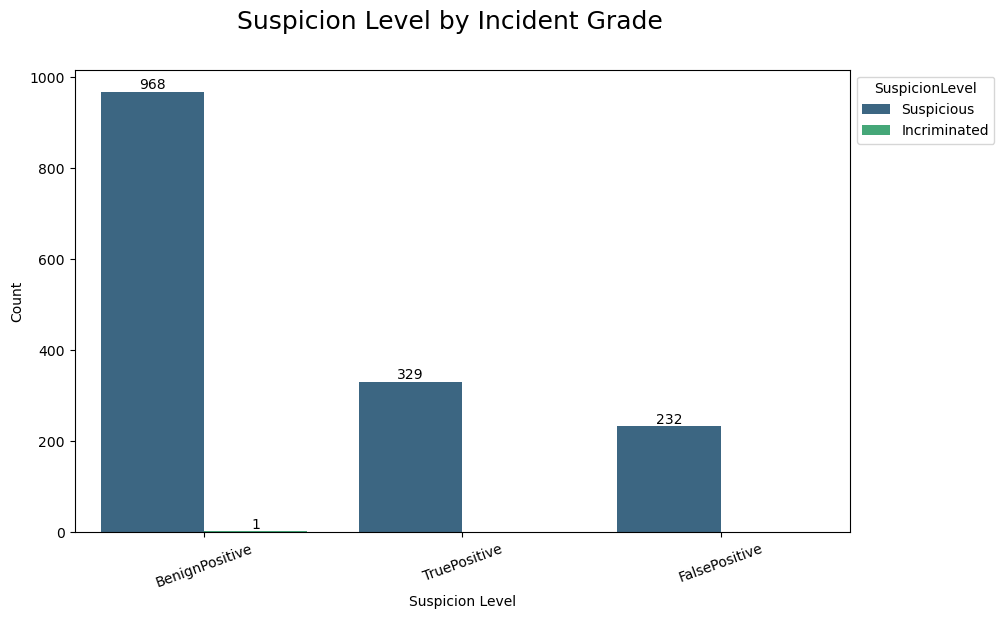

In [29]:
# "suspicion level" refers to the degree of confidence that a detected activity is potentially malicious, 
# often indicated by a "suspicious" verdict within an alert, meaning the system believes there is a high likelihood of a threat 
# but further investigation is needed before taking definitive action; this level can be considered as a 
# middle ground between "clean" (not malicious) and "malicious" (confirmed threat)

# Explore SuspicionLevel feature along with IncidentGrade

# Plot SuspicionLevel with IncidentGrade
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df_train, x='IncidentGrade', hue='SuspicionLevel', palette='viridis', order=df_train['IncidentGrade'].value_counts().index)
render_plot(ax, heading='Suspicion Level by Incident Grade', xlabel='Suspicion Level', ylabel='Count')



### EDA Numerical Data

In [30]:
# Add a numerical feature for IncidentGrade
df_train['IncidentGradeNum'] = df_train['IncidentGrade'].map({'TruePositive': 1, 'FalsePositive': -1, 'BenignPositive': 0})

In [31]:
df_train['IncidentGradeNum'].value_counts()

IncidentGradeNum
 0.0    4391
 1.0    3446
-1.0    2110
Name: count, dtype: int64

In [32]:
# Analyze Geographical Features

num_features_geo = ['CountryCode', 'State', 'City', 'IncidentGradeNum']

# Top 10 countries by Incident Grade
top_10_countries = df_train['CountryCode'].value_counts().head(10)
print(top_10_countries)

# Top 10 countries/state/city by Incident Grade
top_10_country_states = df_train.groupby(['CountryCode', 'State', 'City']).size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
top_10_country_states

CountryCode
242    9232
0       177
1       119
2        59
4        43
5        34
3        29
6        25
7        19
9        19
Name: count, dtype: int64


,CountryCode,State,City,size
231,242,1445,10630,9232
70,1,0,0,113
111,5,1445,10630,34
72,2,2,2,25
0,0,1,1,20
1,0,1,5,16
127,8,10,7,14
155,16,1445,10630,13
136,12,12,9,12
103,4,21,23,11


#### Alerts/Incidents by City/state/country
Most alerts/incidents appear to be generated from the same location. 

<Axes: >

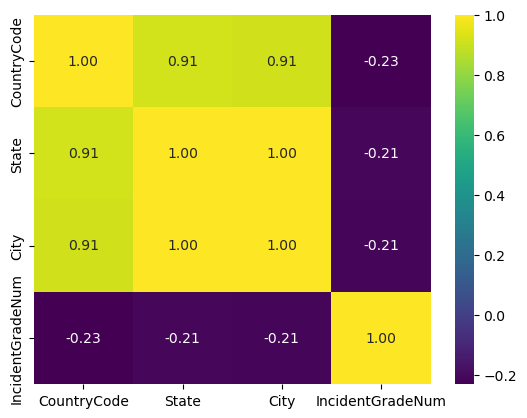

In [33]:
sns.heatmap(df_train[num_features_geo].corr(), annot=True, cmap='viridis', fmt=".2f")

<Axes: >

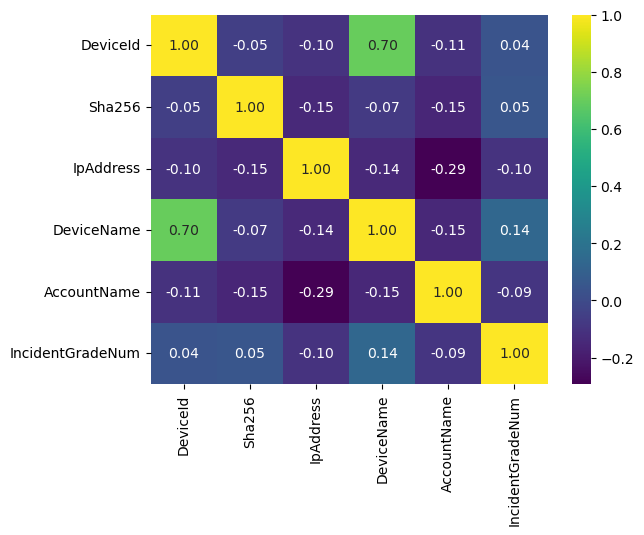

In [34]:
num_features_device = ['DeviceId', 'Sha256', 'IpAddress', 'DeviceName', 'AccountName', 'IncidentGradeNum']

sns.heatmap(df_train[num_features_device].corr(), annot=True, cmap='viridis', fmt=".2f")

<Axes: >

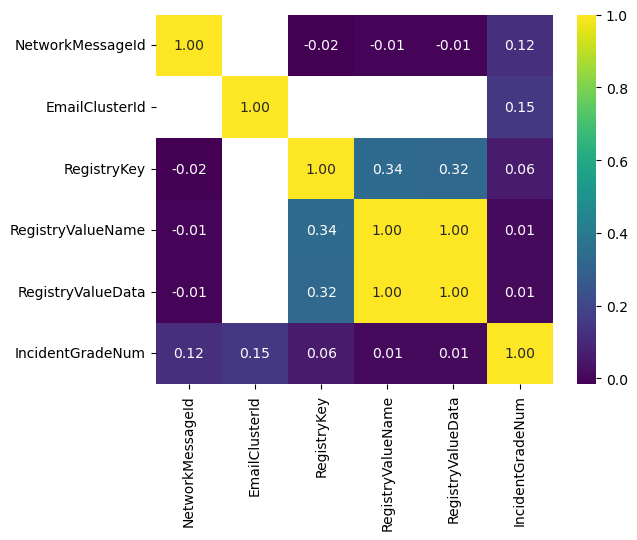

In [35]:
num_features_infr = ['NetworkMessageId', 'EmailClusterId', 'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'IncidentGradeNum']
sns.heatmap(df_train[num_features_infr].corr(), annot=True, cmap='viridis', fmt=".2f")

#### Weak correlation between IncidentGrade and Numerical Features

### Data Clean Up   

In [36]:
# Drop Columns marked in the EDA section

print('Columns to be dropped: ', drop_columns[0])  

df_train.drop(columns=drop_columns[0], axis=1, inplace=True)
df_test.drop(columns=drop_columns[0], axis=1, inplace=True)

Columns to be dropped:  ['MitreTechniques']


### Train/Test Split

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Id                   10000 non-null  int64              
 1   OrgId                10000 non-null  int64              
 2   IncidentId           10000 non-null  int64              
 3   AlertId              10000 non-null  int64              
 4   Timestamp            10000 non-null  datetime64[ns, UTC]
 5   DetectorId           10000 non-null  int64              
 6   AlertTitle           10000 non-null  int64              
 7   Category             10000 non-null  object             
 8   IncidentGrade        9947 non-null   object             
 9   ActionGrouped        59 non-null     object             
 10  ActionGranular       59 non-null     object             
 11  EntityType           10000 non-null  object             
 12  EvidenceRole       

In [38]:
from scipy.sparse import hstack, csr_matrix

# Drop 
# X_train = df_train.drop(columns = ['IncidentGrade'])  
# y_train = df_train['IncidentGrade']

# X_test = df_test.drop(columns = ['IncidentGrade'])  

# categorical columns
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(df_train[cat_columns])

X_train_ohe = ohe.transform(df_train[cat_columns])
X_test_ohe = ohe.transform(df_test[cat_columns])
X_train_data_numerical = csr_matrix(df_train[numerical_columns].fillna(-1).values)
X_test_data_numerical = csr_matrix(df_test[numerical_columns].fillna(-1).values)

X_train = hstack([X_train_ohe, X_train_data_numerical])
X_test = hstack([X_test_ohe, X_test_data_numerical])

le = LabelEncoder()
le.fit(df_train['IncidentGrade'])

y_train = le.transform(df_train['IncidentGrade'])
y_test = le.transform(df_test['IncidentGrade'])


In [39]:
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

0    4391
2    3446
1    2110
3      53
Name: count, dtype: int64
0    4192
2    3641
1    2167
Name: count, dtype: int64


In [40]:
X_train

<10000x147 sparse matrix of type '<class 'numpy.float64'>'
	with 338627 stored elements in Compressed Sparse Row format>

### Basic Classifiers

### Decision Tree

In [41]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [42]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.617
Macro-Precision: 0.4426850398564284
Macro-Recall: 0.4371105060393162
Macro-F1 Score: 0.4390395087804321


/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.67      0.66      4192
           1       0.45      0.38      0.42      2167
           2       0.67      0.69      0.68      3641
           3       0.00      0.00      0.00         0

    accuracy                           0.62     10000
   macro avg       0.44      0.44      0.44     10000
weighted avg       0.61      0.62      0.61     10000



/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/BerkeleyAIML/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
